## Laboratorium 8.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od detekcji obiektów, a może z góry wiemy, gdzie obiekty się początkowo znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---

### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:  
```python
fps = source.get(cv2.CAP_PROP_FPS)
```  
Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps odtwarzane przy typowej prędkości 30fps wyglądałoby na spowolnione w proporcji ok. 1:7.5; zostało zatem przekodowane tak, aby osiągnąć zbieżność upływu czasu 1:1 z rzeczywistym. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).

In [1]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem i postaraj tak dobrać, by uzyskać odpowiednio dużo (10+) punktów w rejonie śledzonego obiektu.

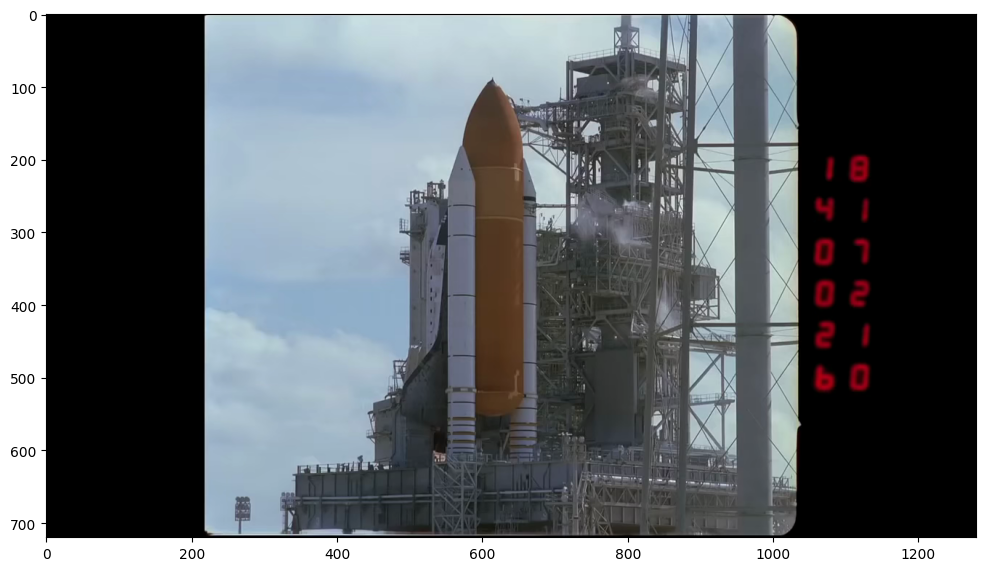

In [2]:
source = cv2.VideoCapture("dane/shuttle.mp4")
status, frame = source.read()
source.release()
plt.subplots(1, 1, figsize=(12, 12))[1].imshow(frame[..., ::-1])

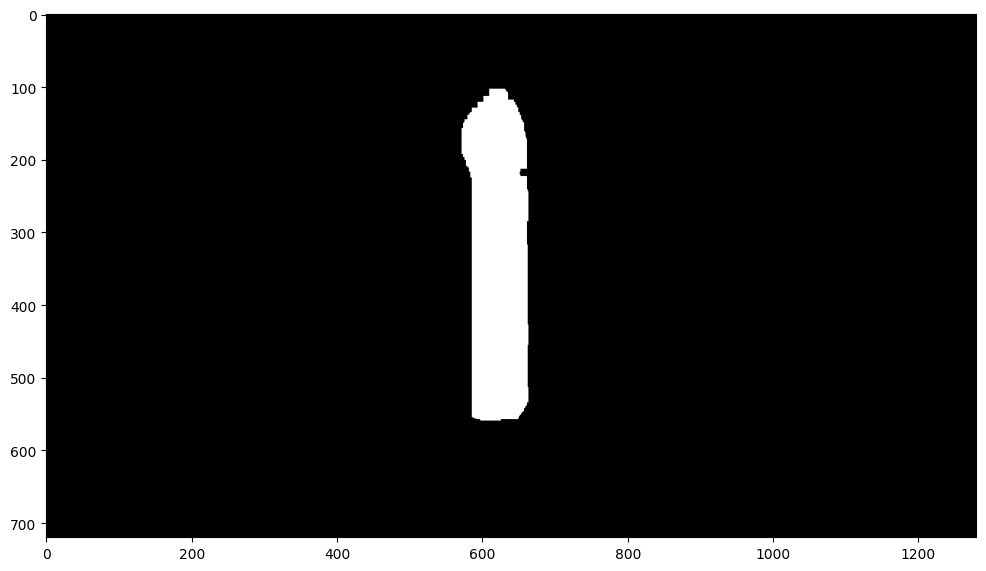

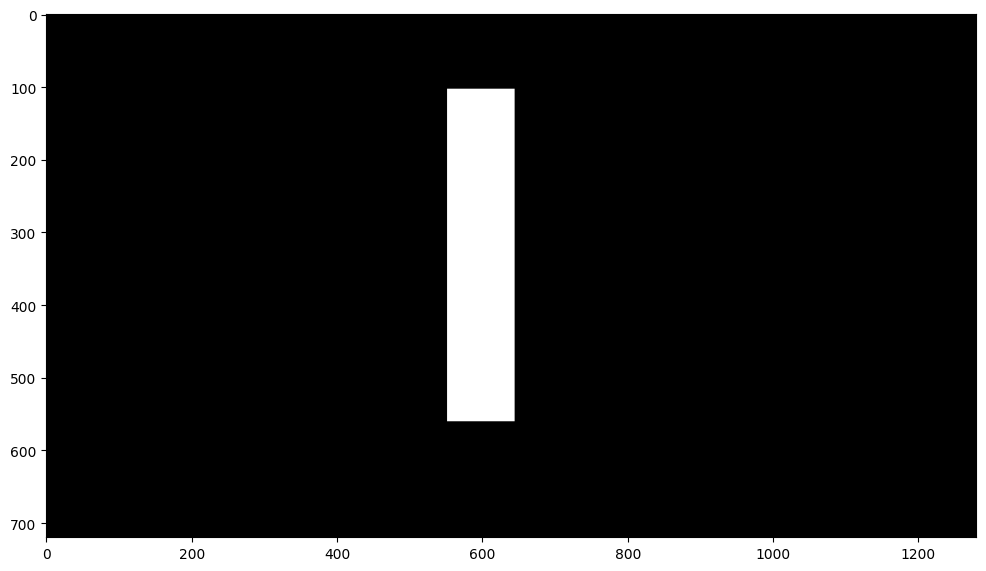

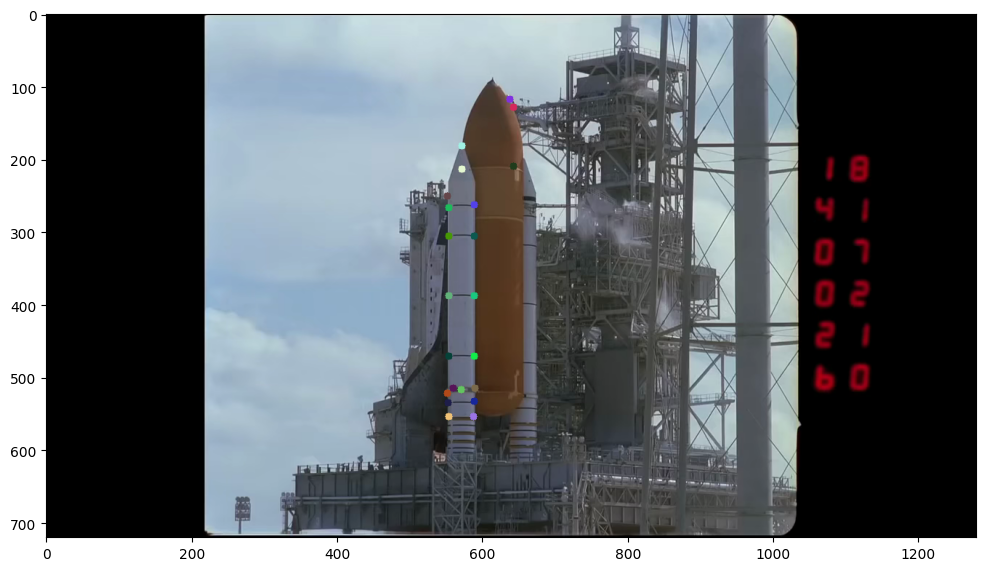

In [3]:
source = cv2.VideoCapture("dane/shuttle.mp4")
status, frame = source.read()
source.release()

# mask the orange color to create good features
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
lower_orange = np.array([0, 90, 50])
upper_orange = np.array([30, 255, 255])
mask = cv2.inRange(hsv, lower_orange, upper_orange)

# dilate the mask
kernel = np.ones((5, 5), np.uint8)

mask = cv2.erode(mask, kernel, iterations=2)
mask = cv2.dilate(mask, kernel, iterations=5)
plt.subplots(1, 1, figsize=(12, 12))[1].imshow(mask, cmap="gray")

# widen the mask
# make a rectangle mask bounding the mask
x, y, w, h = cv2.boundingRect(mask)
mask = cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

# move mask to left by 10 pixels
mask = np.roll(mask, -20, axis=1)


plt.subplots(1, 1, figsize=(12, 12))[1].imshow(mask, cmap="gray")


gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
feature_params = dict(maxCorners=100, qualityLevel=0.1, minDistance=10)

p0 = cv2.goodFeaturesToTrack(gray, mask=mask, **feature_params)
# randomize colors

# cast to int and draw circles
p0 = np.array(p0, dtype=np.int32)
for i in p0:
    x, y = i.ravel()
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.circle(frame, (x, y), 5, color, -1)
plt.subplots(1, 1, figsize=(12, 12))[1].imshow(frame[..., ::-1])

### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).

In [30]:
def baseLoop(source: cv2.VideoCapture):
    frame = None
    status, frame_next = source.read()

    hsv = cv2.cvtColor(frame_next, cv2.COLOR_BGR2HSV)
    lower_orange = np.array([0, 90, 50])
    upper_orange = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_orange, upper_orange)

    mask = cv2.inRange(hsv, lower_orange, upper_orange)

    # dilate the mask
    kernel = np.ones((3, 3), np.uint8)

    mask = cv2.erode(mask, kernel, iterations=2)
    mask = cv2.dilate(mask, kernel, iterations=4)

    frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

    feature_params = dict(maxCorners=100, qualityLevel=0.1, minDistance=3, blockSize=10)

    lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )

    color = np.random.randint(0, 255, (100, 3))

    p0 = cv2.goodFeaturesToTrack(frame_next_gray, mask=mask, **feature_params)

    mask = np.zeros_like(frame_next)

    while status:
        frame = frame_next
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        status, frame_next = source.read()
        # handle
        if not status:
            print("Brak kolejnej klatki")
            break

        frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

        p1, st, err = cv2.calcOpticalFlowPyrLK(
            frame_gray, frame_next_gray, p0, None, **lk_params
        )

        if p1 is not None:
            good_new = p1[st == 1]
            good_old = p0

        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(
                mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2
            )
            frame_next = cv2.circle(
                frame_next, (int(a), int(b)), 5, color[i].tolist(), -1
            )
        img = cv2.add(frame_next, mask)

        cv2.imshow("frame_next", img)
        k = cv2.waitKey(30) & 0xFF
        if k == 27:
            break

        p0 = good_new.reshape(-1, 1, 2)

    source.release()
    cv2.destroyAllWindows()

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


def baseLoop(source: cv2.VideoCapture):
    frame = None
    status, frame_next = source.read()
    if not status:
        print("Failed to read the video source.")
        return

    frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

    feature_params = dict(maxCorners=100, qualityLevel=0.1, minDistance=3, blockSize=10)

    lk_params = dict(
        winSize=(20, 20),
        maxLevel=3,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )

    color = np.random.randint(0, 255, (200, 3))

    p0 = cv2.goodFeaturesToTrack(frame_next_gray, mask=mask, **feature_params)

    mask = np.zeros_like(frame_next)

    plt.ion()
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(cv2.cvtColor(frame_next, cv2.COLOR_BGR2RGB))

    while status:
        frame = frame_next
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        status, frame_next = source.read()

        if not status:
            print("End of video.")
            break

        frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

        p1, st, err = cv2.calcOpticalFlowPyrLK(
            frame_gray, frame_next_gray, p0, None, **lk_params
        )

        if p1 is not None:
            good_new = p1[st == 1]
            good_old = p0[st == 1]

        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(
                mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2
            )
            frame_next = cv2.circle(
                frame_next, (int(a), int(b)), 5, color[i].tolist(), -1
            )
        img = cv2.add(frame_next, mask)

        # Update the plot in the notebook
        im.set_data(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        clear_output(wait=True)
        display(fig)

        p0 = good_new.reshape(-1, 1, 2)

    plt.ioff()
    plt.show()
    source.release()

In [ ]:
baseLoop(cv2.VideoCapture("dane/shuttle.mp4"))

In [52]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


def baseLoopWithAnimation(source: cv2.VideoCapture):
    frames = []
    trajectories = []
    status, frame_next = source.read()
    if not status:
        print("Failed to read the video source.")
        return None, None, None

    hsv = cv2.cvtColor(frame_next, cv2.COLOR_BGR2HSV)
    lower_orange = np.array([0, 90, 50])
    upper_orange = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_orange, upper_orange)

    # dilate the mask
    kernel = np.ones((5, 5), np.uint8)

    mask = cv2.erode(mask, kernel, iterations=2)
    mask = cv2.dilate(mask, kernel, iterations=2)

    x, y, w, h = cv2.boundingRect(mask)
    mask = cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)
    mask = np.roll(mask, -20, axis=1)
    # show

    frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

    feature_params = dict(maxCorners=100, qualityLevel=0.1, minDistance=10, blockSize=1)

    lk_params = dict(
        winSize=(25, 25),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )

    color = np.random.randint(0, 255, (100, 3))
    p0 = cv2.goodFeaturesToTrack(frame_next_gray, mask=mask, **feature_params)
    mask = np.zeros_like(frame_next)

    while status:
        frame = frame_next
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        status, frame_next = source.read()

        if not status:
            break

        frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

        p1, st, err = cv2.calcOpticalFlowPyrLK(
            frame_gray, frame_next_gray, p0, None, **lk_params
        )

        if p1 is not None:
            good_new = p1[st == 1]
            good_old = p0[st == 1]

        subtrajectories = []
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(
                mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2
            )
            frame_next = cv2.circle(
                frame_next, (int(a), int(b)), 5, color[i].tolist(), -1
            )
            subtrajectories.append((a, b, c, d))
        trajectories.append(subtrajectories)
        # pack trajectories into a list

        img = cv2.add(frame_next, mask)

        # Append frames for animation
        frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        p0 = good_new.reshape(-1, 1, 2)

    # Release the video source
    source.release()

    # Create animation
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_axis_off()
    ax.set_title("Optical Flow - Lucas-Kanade method")
    im = ax.imshow(frames[0])
    fig.tight_layout()

    def update(frame):
        im.set_array(frame)
        return [im]

    anim = FuncAnimation(fig, update, frames=frames, interval=30, blit=True)
    plt.close(fig)

    return anim, frames, trajectories

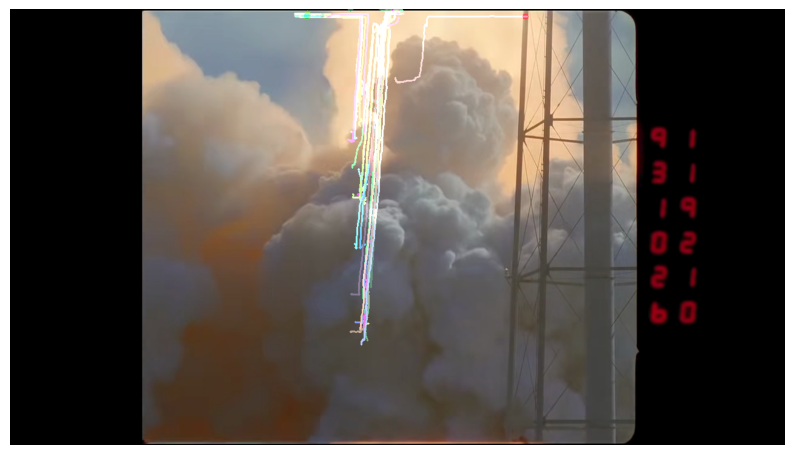

In [53]:
# Example usage
import matplotlib as mpl


# Increase the embed limit to 30 MB
mpl.rcParams["animation.embed_limit"] = 40
source = cv2.VideoCapture("dane/shuttle.mp4")
# skip 4 seconds
# source.set(cv2.CAP_PROP_POS_MSEC, 4000)
fps = source.get(cv2.CAP_PROP_FPS)

html_video, frames, trajectories = baseLoopWithAnimation(source)

# Display the last frame
plt.figure(figsize=(10, 6))
plt.imshow(frames[-1])
plt.axis("off")
plt.show()

In [7]:
# import display and display video
display(HTML(html_video.to_html5_video()))

### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość _Discovery_.

Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością.  
Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.  
Wersja z plusem: zastosuj odpowiednią filtrację funkcji położenia, by uniezależnić funkcję czasu od szumu.

In [42]:
fps_of_shuttle = fps

In [43]:
all_frames = len(frames)
all_frames

359

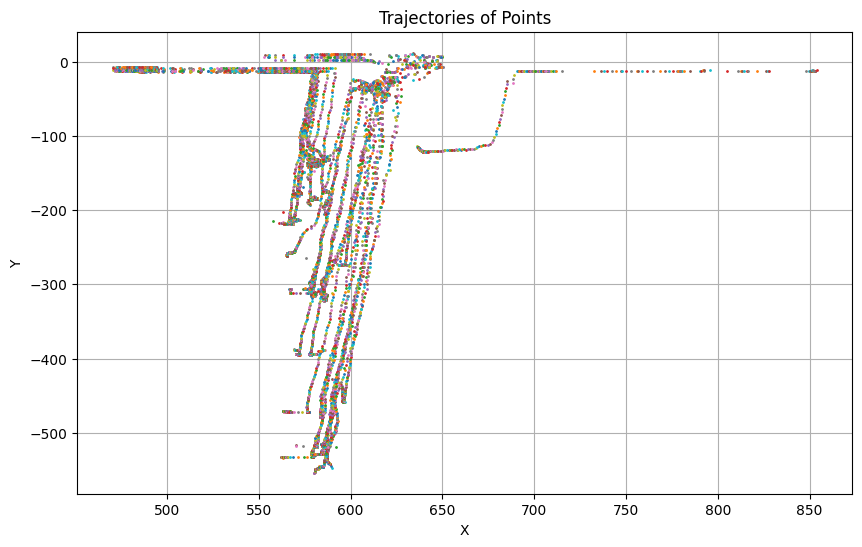

In [69]:
def plot_trajectories(trajectories):
    # Plot trajectories
    plt.figure(figsize=(10, 6))
    for frame_trajectories in trajectories:
        for a, b, _, _ in frame_trajectories:
            plt.plot(a, -b, marker="o", markersize=1)
    plt.title("Trajectories of Points")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


# Call the function with the trajectories list
plot_trajectories(trajectories)

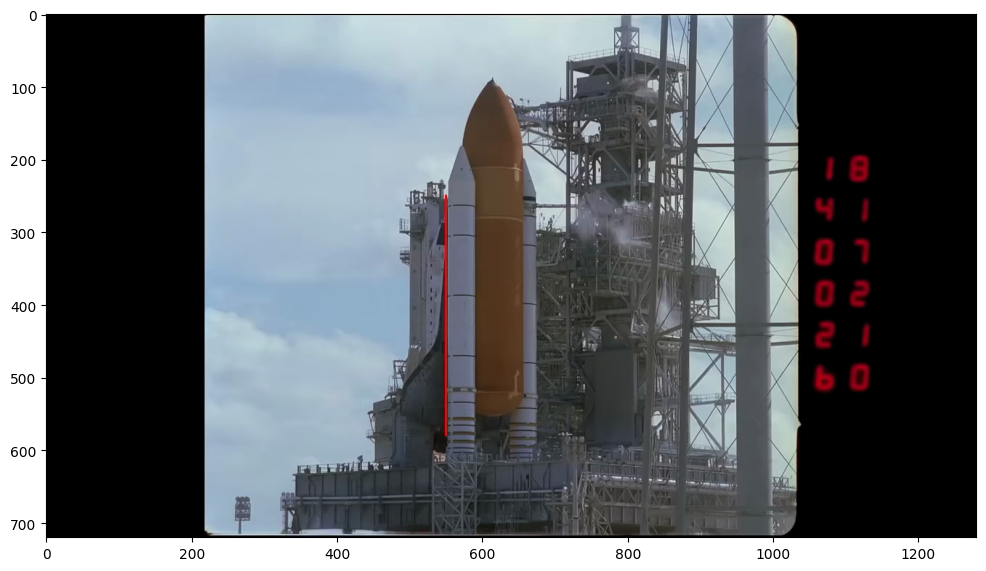

In [24]:
# want to plot a red line between two points ona first frame an set it as 38 meters long, then i want calculate the speed of the shuttle in m/s

# first frame
source = cv2.VideoCapture("dane/shuttle.mp4")
status, frame = source.read()
source.release()

x1, y1 = 550, 250
x2, y2 = 550, 580

# difference is 38 meters
# distance between two points
distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
# scale


frame = cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
plt.subplots(1, 1, figsize=(12, 12))[1].imshow(frame[..., ::-1])

In [28]:
discovery_length = 38

pixel_to_meter = discovery_length / distance

print(f"1 pixel is equal to {pixel_to_meter} meters")

1 pixel is equal to 0.11515151515151516 meters


In [31]:
fps_of_shuttle

30.05348189415042

In [32]:
len(trajectories)

9018

In [36]:
video_time = all_frames / fps_of_shuttle
print(f"Video time: {video_time} seconds")

Video time: 11.945371297223149 seconds


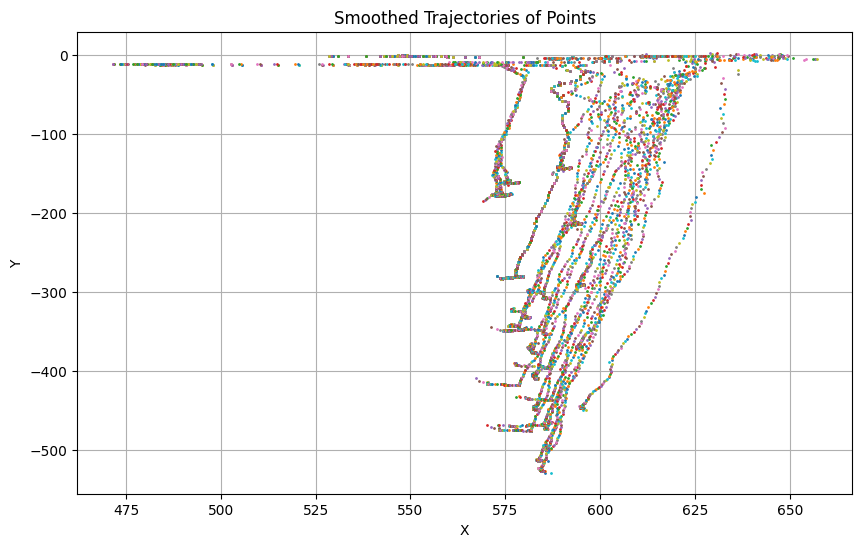

In [ ]:
import numpy as np


def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


def smooth_trajectories(trajectories, window_size=5):
    smoothed_trajectories = []
    for frame_trajectories in trajectories:
        x_coords = [traj[0] for traj in frame_trajectories]
        y_coords = [traj[1] for traj in frame_trajectories]
        smoothed_x = moving_average(x_coords, window_size)
        smoothed_y = moving_average(y_coords, window_size)

        # Pad the smoothed coordinates to match the original length
        pad_x = np.pad(smoothed_x, (0, len(x_coords) - len(smoothed_x)), "edge")
        pad_y = np.pad(smoothed_y, (0, len(y_coords) - len(smoothed_y)), "edge")

        smoothed_frame_trajectories = list(zip(pad_x, pad_y))
        smoothed_trajectories.append(smoothed_frame_trajectories)
    return smoothed_trajectories


smoothed_points = smooth_trajectories(trajectories, window_size=5)


def plot_smoothed_trajectories(smoothed_trajectories):
    plt.figure(figsize=(10, 6))
    for frame_trajectories in smoothed_trajectories:
        for x, y in frame_trajectories:
            plt.plot(x, -y, marker="o", markersize=1)
    plt.title("Smoothed Trajectories of Points")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


plot_smoothed_trajectories(smoothed_points)

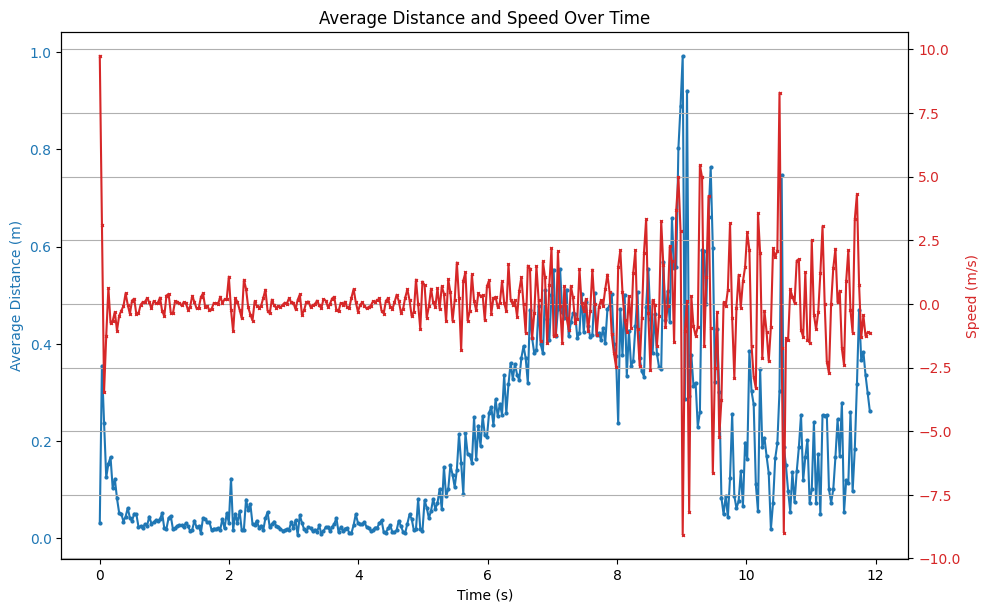

In [ ]:
def calculate_average_distance(trajectories, pixel_to_meter):
    average_distances = []

    for frame_trajectories in trajectories:
        distances = []
        for a, b, c, d in frame_trajectories:
            distance = np.sqrt((a - c) ** 2 + (b - d) ** 2) * pixel_to_meter
            distances.append(distance)
        average_distance = np.mean(distances) if distances else 0
        average_distances.append(average_distance)

    return average_distances


def plot_average_distance_over_time(average_distances, fps):
    time = np.arange(len(average_distances)) / fps
    speed = np.gradient(
        average_distances, time
    )  # Calculate speed as the gradient of distance over time

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = "tab:blue"
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Average Distance (m)", color=color)
    ax1.plot(time, average_distances, marker="o", markersize=2, color=color)
    ax1.tick_params(axis="y", labelcolor=color)

    ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
    color = "tab:red"
    ax2.set_ylabel("Speed (m/s)", color=color)
    ax2.plot(time, speed, marker="x", markersize=2, color=color)
    ax2.tick_params(axis="y", labelcolor=color)

    fig.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.title("Average Distance and Speed Over Time")
    plt.grid(True)
    plt.show()


# Calculate the average distance over time
average_distances = calculate_average_distance(trajectories, pixel_to_meter)

# Plot the average distance over time
plot_average_distance_over_time(average_distances, fps_of_shuttle)

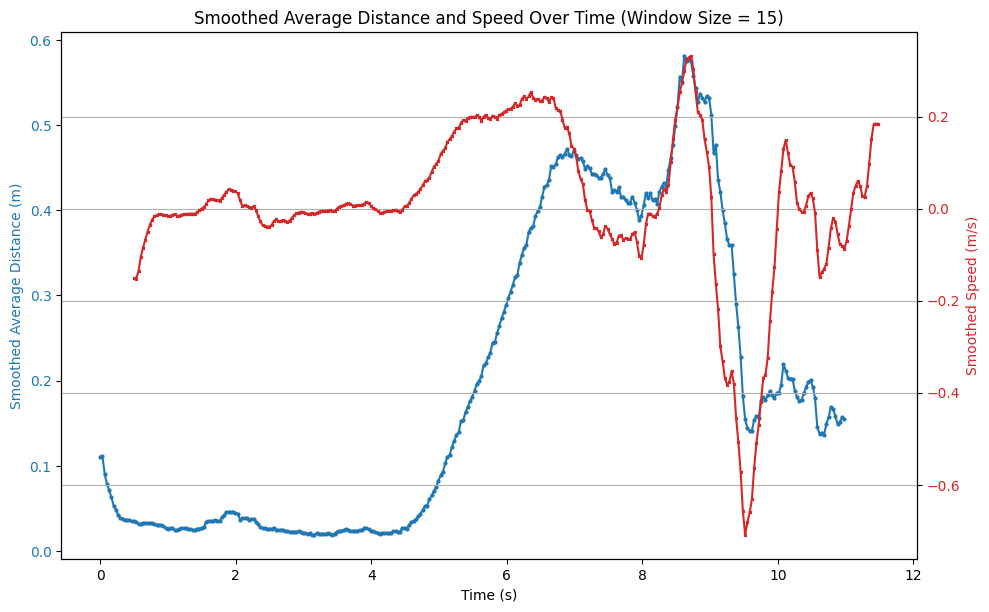

In [89]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


window_size = 15
smoothed_average_distances = moving_average(average_distances, window_size)


def plot_smoothed_average_distance_over_time(
    smoothed_average_distances, fps, window_size
):
    time = np.arange(len(smoothed_average_distances)) / fps
    smoothed_speed = np.gradient(
        smoothed_average_distances, time
    )  # Calculate speed as the gradient of distance over time

    # Smooth the speed every 10 frames
    smoothed_speed = moving_average(smoothed_speed, window_size)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = "tab:blue"
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Smoothed Average Distance (m)", color=color)
    ax1.plot(
        time[: len(smoothed_speed)],
        smoothed_average_distances[: len(smoothed_speed)],
        marker="o",
        markersize=2,
        color=color,
    )
    ax1.tick_params(axis="y", labelcolor=color)

    ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
    color = "tab:red"
    ax2.set_ylabel("Smoothed Speed (m/s)", color=color)
    ax2.plot(
        time[: len(smoothed_speed)] + window_size / fps,
        smoothed_speed,
        marker="x",
        markersize=2,
        color=color,
    )
    ax2.tick_params(axis="y", labelcolor=color)

    fig.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.title(
        f"Smoothed Average Distance and Speed Over Time (Window Size = {window_size})"
    )
    plt.grid(True)
    plt.show()


# Plot the smoothed average distance over time
plot_smoothed_average_distance_over_time(
    smoothed_average_distances, fps_of_shuttle, window_size
)

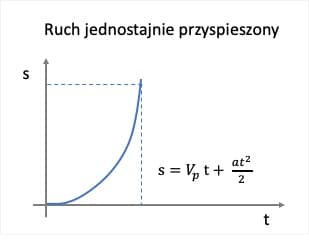

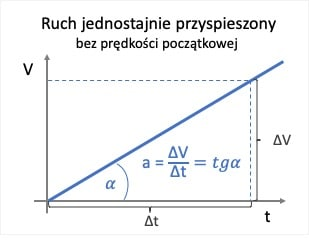

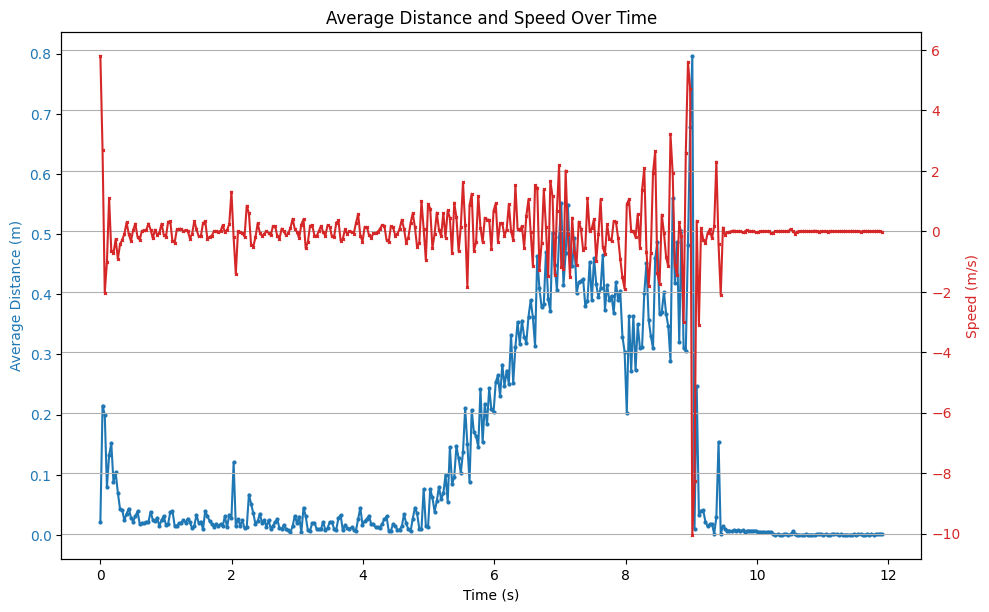

In [90]:
def calculate_average_distance_y(trajectories, pixel_to_meter):
    average_distances = []

    for frame_trajectories in trajectories:
        distances = []
        for a, b, c, d in frame_trajectories:
            distance = np.abs(b - d) * pixel_to_meter
            distances.append(distance)
        average_distance = np.mean(distances) if distances else 0
        average_distances.append(average_distance)

    return average_distances


def plot_average_distance_over_time_y(average_distances, fps):
    time = np.arange(len(average_distances)) / fps
    speed = np.gradient(
        average_distances, time
    )  # Calculate speed as the gradient of distance over time

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = "tab:blue"
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Average Distance (m)", color=color)
    ax1.plot(time, average_distances, marker="o", markersize=2, color=color)
    ax1.tick_params(axis="y", labelcolor=color)

    ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
    color = "tab:red"
    ax2.set_ylabel("Speed (m/s)", color=color)
    ax2.plot(time, speed, marker="x", markersize=2, color=color)
    ax2.tick_params(axis="y", labelcolor=color)

    fig.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.title("Average Distance and Speed Over Time")
    plt.grid(True)
    plt.show()


# Calculate the average distance over time
average_distances_y = calculate_average_distance_y(trajectories, pixel_to_meter)

# Plot the average distance over time
plot_average_distance_over_time_y(average_distances_y, fps_of_shuttle)

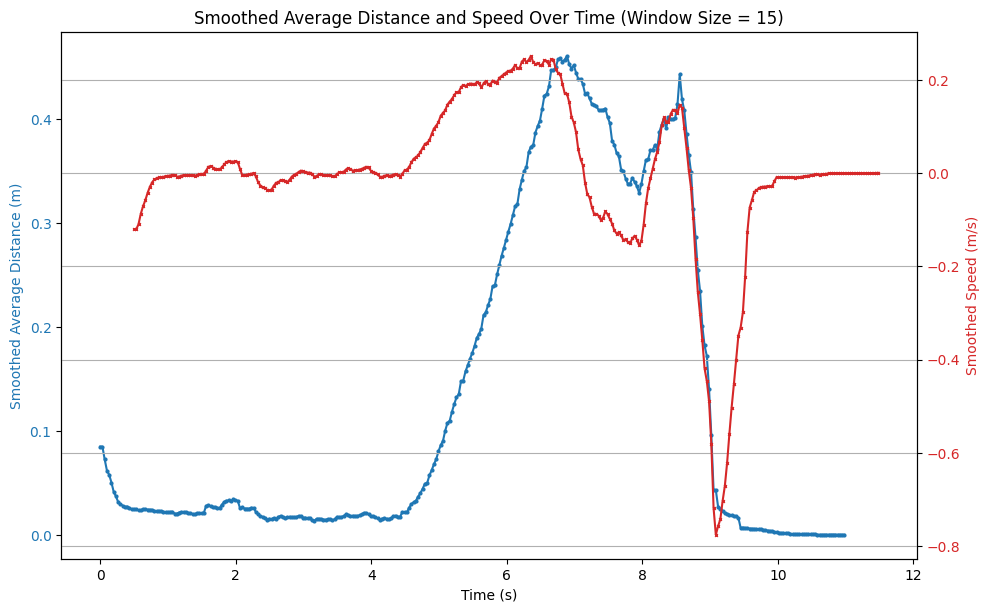

In [91]:
window_size = 15
smoothed_average_distances_y = moving_average(average_distances_y, window_size)

plot_smoothed_average_distance_over_time(
    smoothed_average_distances_y, fps_of_shuttle, window_size
)